# Efficiently sampling GP posteriors

Advances in Gaussian Process (GP) approximations, most notably the [Variational Free Energy (VFE) approximation](./vfe), {cite}`titsias2009variational` are extremely useful for reducing the computational cost of training GPs as well as evaluating their posteriors. VFE brings the cost of training and fitting GPs from $\mathcal{O}(N^3)$ down to $\mathcal{O}(NM^2)$, where $N$ is the number of datapoints and $M$ is the number of inducing points. However, drawing samples from the approximate posterior produced by VFE still has a complexity of $\mathcal{O}(K^3)$ where $K$ is the number of query locations, which can become prohibitively expensive. This cost is due to a term in the covariance of the VFE approximate posterior, which is due the GP prior. This term is not an issue while _training_ GPs, but it does become an issue when _sampling the posterior_. Posterior samples are often necessary for estimating downstream quantities, such as Monte Carlo integrals. Another related issue is that of drawing differentiable function samples. In some use cases, such as Baysian Optimisation (BO) with Thompson sampling, we not only want to draw a function sample, but also access its derivative in order to find its maximum. Recent exciting work {cite}`wilson2020efficiently` has enabled not only efficiently sampling VFE posteriors but obtaining function samples which can be evaluated, and differentiated, at every input location, thus getting around both of the aforementioned issues. $ \def\Kxx{\mathbf{K}_{\mathbf{X}\mathbf{X}}}
 \def\Kxb{\mathbf{K}_{\mathbf{X}\mathbf{\bar{X}}}}
 \def\Kbx{\mathbf{K}_{\mathbf{\bar{X}}\mathbf{X}}}
 \def\Kbb{\mathbf{K}_{\mathbf{\bar{X}}\mathbf{\bar{X}}}}
 \def\Ksb{\mathbf{K}_{\mathbf{X^*}\mathbf{\bar{X}}}}
 \def\Kbs{\mathbf{K}_{\mathbf{\bar{X}}\mathbf{X^*}}}
 \def\Ksx{\mathbf{K}_{\mathbf{X^*}\mathbf{\bar{X}}}}
 \def\Kxs{\mathbf{K}_{\mathbf{\bar{X}}\mathbf{X^*}}}
 \def\Kss{\mathbf{K}_{\mathbf{X^*}\mathbf{X^*}}}
 \def\fx{\mathbf{f}_{\mathbf{X}}}
 \def\fnb{f_{\neq \mathbf{\bar{X}}}}
 \def\fb{\mathbf{f}_{\mathbf{\bar{X}}}}
 \def\fstar{\mathbf{f}_{\mathbf{X^*}}}
 \def\y{\mathbf{y}}
 \def\X{\mathbf{x}}
 \def\xstar{\mathbf{x^*}}
 \def\X{\mathbf{X}}
 \def\Xb{\mathbf{\bar{X}}}
 \def\Xs{\mathbf{X^*}}
 \def\lrb[#1]{\left(#1\right)}
 \def\lrs[#1]{\left[#1\right]}
 \def\mb[#1]{\mathbf{#1}}
 \DeclareMathOperator*{\argmax}{arg\,max}
 \DeclareMathOperator*{\argmin}{arg\,min}
 \newcommand{\bs}[1]{\boldsymbol{#1}}
 \newcommand{\bm}[1]{\mathbf{#1}} $

In [22]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pltx

from IPython.display import HTML, set_matplotlib_formats

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

set_matplotlib_formats('pdf', 'svg')
css_style = open('../../../_static/custom_style.css', 'r').read()
HTML(f'<style>{css_style}</style>')

## VFE approximate posterior

In exact GP regression, we are typically intersted in placing a GP prior over a latent function $f$, written as

$$\begin{align}
f \sim \mathcal{GP}(m, k),
\end{align}$$

where $m$ is the mean function, hereafter assumed to be $0$ without loss of generality, and $k$ is the covariance function. We model observations $y_n$ via an observation model with Gaussian noise

$$\begin{align}
y_n = f_n + \epsilon_n, \text{ where } \epsilon_n \sim \mathcal{N}(0, \sigma^2).
\end{align}$$

Conditioning on data with inputs $\mathbf{X} = (\mathbf{x}_1, ..., \mathbf{x}_N)^\top$ and outputs $\mathbf{y} = (y_1, ..., y_N)^\top$ and using Bayes' rule, we obtain the exact GP posterior for the latent function $f$ at a set of prediction locations $\mathbf{X}^*$, written $\mathbf{f}_{\mathbf{X}^*}$, as

$$\begin{align}
p(\mathbf{f}_{\mathbf{X^*}} | \mathbf{X^*}, \mathbf{X}, \mathbf{y}) &= \mathcal{N}(\mathbf{f}; \mathbf{m}, \mathbf{K}), \\
\end{align}$$

where the mean vector $\mathbf{m}$ and covariance matrix $\mathbf{K}$ are given by

$$\begin{align}
\mathbf{m} &= \mathbf{K}_{\mathbf{X^*}\mathbf{X}} \left(\mathbf{K}_{\mathbf{X}\mathbf{X}} + \sigma^2 \mathbf{I} \right)^{-1} \mathbf{y}, \\
\mathbf{K} &= \mathbf{K}_{\mathbf{X^*}\mathbf{X^*}} - \mathbf{K}_{\mathbf{X^*}\mathbf{X}} \left(\mathbf{K}_{\mathbf{X}\mathbf{X}} + \sigma^2 \mathbf{I} \right)^{-1} \mathbf{K}_{\mathbf{X}\mathbf{X^*}}.
\end{align}$$

and the boldface $\mathbf{K}_{\cdot, \cdot}$ matrices are given by evaluating the covariance function $k$ at the locations specified by the subscripts. Computing this posterior, or evaluating the marginal log-liklihood $\log p(\mathbf{y} | \mathbf{X})$, involves a computational cost of $\mathcal{O}(N^3)$, where $N$ is the number of datapoints we are conditioning on. The computational bottleneck in these expressions is the matrix inversion displayed above. The [Variational Free Energy (VFE) approximation](./vfe) for GPs gets around this issue by using an approximate posterior with pseudo-points at a learnable set of locations $\Xb$. The posterior mean and covariance under this approximation are

$$\begin{align}
\mathbf{m} &= \sigma^{-2} \Ksb \bs{\Sigma}^{-1} \Kbx \mathbf{y}, \\
\mathbf{K} &= \Kss - \Ksb \Kbb^{-1}\Kbs + \Ksb \bs{\Sigma}^{-1}\Kbs, \\
\bs{\Sigma} &= \lrb[\Kbb + \sigma^{-2} \Kbx \Kxb].
\end{align}$$

These expressions require the inversion of the (smaller) $\bs{\Sigma}$ matrix, reducing the computational cost down to $\mathcal{O}(NM^2)$, where $M$ is the number of pseudopoints.

Unfortunately, sampling from this posterior is still very costly, because it requires computing the Cholesky factor of the $\mathbf{K}$ matrix, which still involves a $\Kss$ factor. The cost of Cholesky factorisation still scales cubically as $\mathcal{O}(K^3)$, where $K$ is the number of locations $\Xs$ at which to sample, which is prohibitively expensive. The procedure developed by Wilson et al. {cite}`wilson2020efficiently` gets around this difficulty in an elegant way which combines existing approximations to efficiently draw approximate samples from the VFE posterior.

## Matheron's rule

We start from Matheron's rule for Gaussian random variables, stated and proved below.

<div class="lemma">
    
**Lemma (Matheron's rule)** Suppose $\mathbf{a}$ and $\mathbf{b}$ are jointly distributed Gaussian random variables. Then
    
$$\begin{align}
\mathbf{a} | (\mathbf{b} = \boldsymbol{\beta}) \stackrel{d}{=} \mathbf{a} + \text{Cov}(\mathbf{a}, \mathbf{b}) \text{Cov}(\mathbf{b}, \mathbf{b})^{-1} (\boldsymbol{\beta} - \mathbf{b}),
\end{align}$$

where $\stackrel{d}{=}$ denotes equality in distribution.
    
</div>
<br>

<details class="proof">
<summary>Derivation: Matheron's rule</summary>

Computing the mean of the right hand side, we see
    
$$\begin{align}
\mathbb{E} \left[ \mathbf{a} + \text{Cov}(\mathbf{a}, \mathbf{b}) \text{Cov}(\mathbf{b}, \mathbf{b})^{-1} (\boldsymbol{\beta} - \mathbf{b}) \right] = \mathbf{m}_{\mathbf{a}} + \text{Cov}(\mathbf{a}, \mathbf{b}) \text{Cov}(\mathbf{b}, \mathbf{b})^{-1} (\boldsymbol{\beta} - \mathbf{m}_{\mathbf{b}}),
\end{align}$$
    
where $\mathbf{m}_{\mathbf{a}}$ and $\mathbf{m}_{\mathbf{b}}$ are the prior means of $\mathbf{a}$ and $\mathbf{b}$. We see that the right-hand side is precisely the expression for the mean of $\mathbf{a}$ conditioned on $\mathbf{b} = \boldsymbol{\beta}$. Simlilarly, taking covariances of both sides we obtain
    
$$\begin{align}
\text{Cov} \left[ \mathbf{a} + \text{Cov}(\mathbf{a}, \mathbf{b}) \text{Cov}(\mathbf{b}, \mathbf{b})^{-1} (\boldsymbol{\beta} - \mathbf{b}) \right] = \text{Cov}(\mathbf{a}, \mathbf{a}) - \text{Cov}(\mathbf{a}, \mathbf{b}) \text{Cov}(\mathbf{b}, \mathbf{b})^{-1} \text{Cov}(\mathbf{b}, \mathbf{a}),
\end{align}$$
    
which is exactly the expression of the conditional of a Gaussian distribution. 
    
</details>
<br>

Matheron's rule therefore gives a straightforward way to condition a variable $\mathbf{a}$ on the event $\mathbf{b} = \boldsymbol{\beta}$ _after the variables_ $\mathbf{a}$ _and_ $\mathbf{b}$ _have been sampled from the prior_. In particular, if we already have jointly sampled $\mathbf{a}$ and $\mathbf{b}$ from the prior Gaussian, we can adjust $\mathbf{a}$ by adding $\text{Cov}(\mathbf{a}, \mathbf{b}) \text{Cov}(\mathbf{b}, \mathbf{b})^{-1} (\boldsymbol{\beta} - \mathbf{b})$ to it, to obtain a valid sample of $\mathbf{a} | (\mathbf{b} = \boldsymbol{\beta})$.

In the case of VFE GPs, the joint distribution of the latent function at the inducing locations $\mathbf{f}_{\mathbf{\bar{X}}}$ and the latent function at the prediction locations $\mathbf{f}_{\mathbf{\bar{X}}}$ is Gaussian. Therefore, we can draw a sample from the approximate posterior by first sampling $\mathbf{f}_{\Xs}$ and $\mathbf{f}_{\Xb}$ from the GP prior, then draw a sample $\mathbf{u} \sim \mathbf{f}_{\Xb} | \mathbf{X}, \mathbf{\bar{X}}, \mathbf{y}$ from the approximate posterior over the inducing values and lastly adjust $\mathbf{f}_{\Xs}$ according to Matheron's rule

$$\begin{align}
\mathbf{f}_{\Xs} \leftarrow \mathbf{f}_{\Xs} + \Ksb \Kbb^{-1} (\mathbf{u} - \mathbf{f}_{\Xb}).
\end{align}$$

This procedure thus draws a sample from the prior, and adjusts it in accordance to the event that the inducing point values are $\mathbf{f}_{\Xb} = \mathbf{u}$, giving exact samples from the (approximate) VFE posterior. However, jointly sampling $\mathbf{f}_{\Xb}$ and $\mathbf{f}_{\Xs}$ from the prior still involves an expensive Cholesky factorisation, since we now have to factorise the covariance matrix corresponding to both the $\Xb$ and $\Xs$ locations. Fortunately, for a broad class of covariance matrices, we can cheaply draw approximate samples from the prior using [Random Fourier Features (RFF)](../../misc/rff/rff) {cite}`rahimi2007random`. We can then plug these approximate samples to Matheron's rule to obtain approximate samples from the VFE posterior. Random Fourier Features are applicable to stationary covariances such as the EQ, Matern, Laplace or Cauchy covariances. Given such a covariance, the RFF algorithm produces a randomly sampled set of sinusoids $\boldsymbol{\phi}(\mathbf{x}) = (\phi_1(\mathbf{x}), ..., \phi_F(\mathbf{x}))^\top$, where $F$ is a prespecified number of sinusoids to use, such that the linear-in-the-parameters model

$$\begin{align}
f(\mathbf{x}) = \boldsymbol{\phi}(\mathbf{x})^\top \mathbf{w}, \text{ where } \mathbf{w} \sim \mathcal{N}(\mathbf{0}, \sigma^2 \mathbf{I}).
\end{align}$$

has, in expectation, a covariance $k$. The cost of sampling RFFs is _linear_ in the number of features $F$ to draw, thereby avoiding computing a Cholesky factor of the prior covariance. This comes at the cost that the prior samples are now approximate, however the quality of these samples can be improved by using more features while the quality of the approximate samples can itself be quantitatively guaranteed (see Wilson et al. {cite}`wilson2020efficiently` for quantitative bounds on this approximation). Putting everything together, we arrive at the following algorithm for drawin approximate samples from the VFE GP posterior, referred to as pathwise conditioning.

<div class="lemma">
    
**Algorithm (Approximate sampling via pathwise conditioning)** Given a VFE GP with a covariance function $k$ and a distribution $q$ over the inducing point values $\mathbf{u}$, with corresponding inducing inputs $\Xb$, the following proceduree yields an approximate sample from the VFE posterior
    
1. Sample $\mathbf{u} \sim q(\mathbf{u})$.
2. Sample $\boldsymbol{\phi}(\cdot) = (\phi_1(\cdot), ..., \phi_F(\cdot))^\top$ using the RFF approximation.
2. Sample weights $\mathbf{w} = (w_1, ..., w_F)^\top$, where $w_i \sim \mathcal{N}(0, 1)$ independently. 
3. Return the function
    
$$\begin{align}
f(\cdot) = \boldsymbol{\phi}(\cdot)^\top \mathbf{w} + \mathbf{K}_{\cdot, \Xb} \mathbf{K}_{\Xb, \Xb}^{-1} \big(\mathbf{u} - \boldsymbol{\phi}\big(\Xb\big)^\top \mathbf{w}\big).
\end{align}$$
    
</div>
<br>

## Implementation

We can now implement this algorithm, reusing code from the examples on the [VFE approximation](./vfe), as well as the [RFF approximation](../../misc/rff/rff). First we write down the `ConstantMean` and `EQCovariance` classes, adding the `sample_rff` method to the `EQCovariance` class. This draws an RFF sample from the GP prior, and returns this as a function `rff`, which can be queried and differentiated at any input location in constant time.

In [23]:
import tensorflow as tf
import tensorflow_probability as tfp

class ConstantMean(tf.keras.Model):

    def __init__(self,
                 dtype,
                 name='constant_mean'):
        
        super().__init__(name=name, dtype=dtype)
        
        self.constant = tf.Variable(tf.constant(0., dtype=dtype))
        
        
    def __call__(self, x):
        return self.constant * tf.ones(x.shape[0], dtype=self.dtype)
    
    
class EQcovariance(tf.keras.Model):

    def __init__(self, 
                 log_coeff,
                 log_scales,
                 dim,
                 dtype,
                 trainable=True,
                 name='eq_covariance',
                 **kwargs):
        
        super().__init__(name=name, dtype=dtype, **kwargs)
    
        # Convert parameters to tensors
        log_coeff = tf.convert_to_tensor(log_coeff, dtype=dtype)
        log_scales = tf.convert_to_tensor(log_scales, dtype=dtype)

        # Reshape parameter tensors
        log_coeff = tf.squeeze(log_coeff)
        log_scales = tf.reshape(log_scales, (-1,))
        
        # Set input dimensionality
        self.dim = dim
        
        # Set EQ parameters
        self.log_scales = tf.Variable(log_scales, trainable=trainable)
        self.log_coeff = tf.Variable(log_coeff, trainable=trainable)
        
        
    def __call__(self,
                 x1,
                 x2,
                 diag=False,
                 epsilon=None):
        
        # Convert to tensors
        x1 = tf.convert_to_tensor(x1, dtype=self.dtype)
        x2 = tf.convert_to_tensor(x2, dtype=self.dtype)

        # Get vector of lengthscales
        scales = self.scales
        
        # If calculating full covariance, add dimensions to broadcast
        if not diag:

            x1 = x1[:, None, :]
            x2 = x2[None, :, :]

            scales = self.scales[None, None, :] ** 2

        # Compute quadratic, exponentiate and multiply by coefficient
        quad = - 0.5 * (x1 - x2) ** 2 / scales
        quad = tf.reduce_sum(quad, axis=-1)
        eq_cov = self.coeff ** 2 * tf.exp(quad)
        
        # Add jitter for invertibility
        if epsilon is not None:
            eq_cov = eq_cov + epsilon * tf.eye(eq_cov.shape[0], 
                                               dtype=self.dtype)

        return eq_cov
        
    
    @property
    def scales(self):
        return tf.math.exp(self.log_scales)
    
    
    @property
    def coeff(self):
        return tf.math.exp(self.log_coeff)
    
    
    def sample_rff(self, num_features):

        # Dimension of data space
        x_dim = self.scales.shape[0]
        omega_shape = (num_features, x_dim)

        omega = tf.random.normal(shape=(num_features, x_dim), dtype=self.dtype)

        # Scale omegas by lengthscale
        omega = omega / self.scales[None, :]

        # Draw normally distributed RFF weights
        weights = tf.random.normal(mean=0.,
                                   stddev=1.,
                                   shape=(num_features,),
                                   dtype=self.dtype)

        phi = tf.random.uniform(minval=0.,
                                maxval=(2 * np.pi),
                                shape=(num_features, x_dim),
                                dtype=self.dtype)

        def rff(x):
        
            features = tf.cos(tf.einsum('fd, nd -> fn', omega, x) + phi)
            features = (2 / num_features) ** 0.5 * features * self.coeff

            return tf.einsum('f, fn -> n', weights, features)

        return rff

### Sanity check and sampling

We can sanity check the classes above by using them to sample data from a GP with a zero mean and an EQ covariance, and compute the ground truth posterior, shown below. The implementation seems to be working correctly.

In [24]:
# Set random seed and tf.dtype
np.random.seed(0)
dtype = tf.float64

# Num. observations (N)
N = 100

# EQ covariance hyperparameters
log_coeff = 0.
log_scale = 0.
noise = 1e-2
dim = 1

# Initialise covariance
ground_truth_cov = EQcovariance(log_coeff=log_coeff,
                                log_scales=log_scale,
                                dim=dim,
                                dtype=dtype)

# Pick inputs at random
x_train = np.random.uniform(low=-4., high=4., size=(N, 1))

# Compute covariance matrix terms
K_train_train = ground_truth_cov(x_train, x_train, epsilon=1e-12)
I_noise = noise * np.eye(N)

# Sample f_ind | x_ind
y_train = np.dot(np.linalg.cholesky(K_train_train + I_noise),
                 np.random.normal(loc=0., scale=1., size=(N, 1)))

# Locations to plot mean and variance of generative model, y_plot | f_ind, x_plot
x_plot = np.linspace(-8., 8., 100)[:, None]

# Covariances between inducing points and input locations
K_train_plot = ground_truth_cov(x_train, x_plot)
K_plot_train = ground_truth_cov(x_plot, x_train)
K_plot_diag = ground_truth_cov(x_plot, x_plot, diag=True)

# Mean and standard deviation of y_plot | f_ind, x_plot
y_plot_mean = np.dot(K_plot_train, np.linalg.solve(K_train_train + I_noise, y_train))[:, 0]
f_plot_var = K_plot_diag - np.diag(np.dot(K_plot_train,
                                   np.linalg.solve(K_train_train + I_noise, K_train_plot)))
y_plot_var = f_plot_var + noise
y_plot_std = y_plot_var ** 0.5

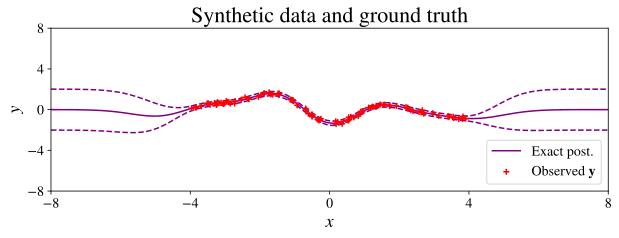

In [35]:
# Plot inducing points and observed data
plt.figure(figsize=(10, 3))
    
# Plot exact posterior predictive
plt.plot(x_plot, y_plot_mean - 2*y_plot_std, '--', color='purple',  zorder=2)
plt.plot(x_plot, y_plot_mean, color='purple',  zorder=2, label='Exact post.')
plt.plot(x_plot, y_plot_mean + 2*y_plot_std, '--', color='purple',  zorder=2)

# Plot sampled data
plt.scatter(x_train,
            y_train,
            color='red',
            marker='+',
            zorder=3,
            label=r'Observed $\mathbf{y}$')

# Plot formatting
plt.title('Synthetic data and ground truth', fontsize=22)
plt.xticks(np.arange(-8, 9, 4), fontsize=14)
plt.yticks(np.arange(-8, 9, 4), fontsize=14)
plt.legend(loc='lower right', fontsize=14)

plt.xlim([-8., 8.])

plt.xlabel('$x$', fontsize=18)
plt.ylabel('$y$', fontsize=18)

plt.show()

### The model

Now let's implement the GP which we will sample from. We will use the implementation we have for GPs approximated using the [VFE approximation](./vfe.ipynb). The only new bit here is the method `sample_posterior`. This method returns a posterior sample, which is itself a function which can be queried at arbitrary inputs.

In [26]:
class VFEGP(tf.keras.Model):
    
    def __init__(self,
                 x_train,
                 y_train,
                 x_ind_init,
                 mean,
                 cov,
                 log_noise,
                 trainable_noise,
                 dtype,
                 name='vfe_gp',
                 **kwargs):
        
        super().__init__(name=name, dtype=dtype, **kwargs)
        
        # Set training data and inducing point initialisation
        self.x_train = tf.convert_to_tensor(x_train, dtype=dtype)
        self.y_train = tf.convert_to_tensor(y_train, dtype=dtype)
        
        # Set inducing points
        self.x_ind = tf.convert_to_tensor(x_ind_init, dtype=dtype)
        self.x_ind = tf.Variable(self.x_ind)
        
        # Set mean and covariance functions
        self.mean = mean
        self.cov = cov
    
        # Set log of noise parameter
        self.log_noise = tf.convert_to_tensor(log_noise, dtype=dtype)
        self.log_noise = tf.Variable(self.log_noise, trainable=trainable_noise)
    
    @property
    def noise(self):
        return tf.math.exp(self.log_noise)
        
    def post_pred(self, x_pred):
        
        # Number of training points
        N = self.y_train.shape[0]
        M = self.x_ind.shape[0]
        
        # Compute covariance terms
        K_ind_ind = self.cov(self.x_ind, self.x_ind, epsilon=1e-9)
        K_train_ind = self.cov(self.x_train, self.x_ind)
        K_ind_train = self.cov(self.x_ind, self.x_train)
        K_pred_ind = self.cov(x_pred, self.x_ind)
        K_ind_pred = self.cov(self.x_ind, x_pred)
        K_pred_pred_diag = self.cov(x_pred, x_pred, diag=True)
        
        # Compute intermediate matrices using Cholesky for numerical stability
        L, U, A, B, B_chol = self.compute_intermediate_matrices(K_ind_ind,
                                                                K_ind_train)
        
        # Compute mean
        diff = self.y_train # - self.mean(self.x_train)[:, None]
        beta = tf.linalg.cholesky_solve(B_chol, tf.matmul(U, diff))
        beta = tf.linalg.triangular_solve(tf.transpose(L, (1, 0)),
                                          beta,
                                          lower=False)
        mean = tf.matmul(K_pred_ind / self.noise ** 2, beta)[:, 0]
        
        C = tf.linalg.triangular_solve(L, K_ind_pred)
        D = tf.linalg.triangular_solve(B_chol, C)
        
        # Compute variance
        var = K_pred_pred_diag + self.noise ** 2
        var = var - tf.linalg.diag_part(tf.matmul(C, C, transpose_a=True))
        var = var + tf.linalg.diag_part(tf.matmul(D, D, transpose_a=True))
        
        return mean, var
        
    def free_energy(self):
        
        # Number of training points and inducing points
        N = self.y_train.shape[0]
        M = self.x_ind.shape[0]
        
        # Compute covariance terms
        K_ind_ind = self.cov(self.x_ind, self.x_ind, epsilon=1e-9)
        K_train_ind = self.cov(self.x_train, self.x_ind)
        K_ind_train = self.cov(self.x_ind, self.x_train)
        K_train_train_diag = self.cov(self.x_train, self.x_train, diag=True)
        
        # Compute intermediate matrices using Cholesky for numerical stability
        L, U, A, B, B_chol = self.compute_intermediate_matrices(K_ind_ind,
                                                                K_ind_train)
        
        # Compute log-normalising constant of the matrix
        log_pi = - N / 2 * tf.math.log(tf.constant(2 * np.pi, dtype=self.dtype))
        log_det_B = - tf.reduce_sum(tf.math.log(tf.linalg.diag_part(B_chol)))
        log_det_noise = - N / 2 * tf.math.log(self.noise ** 2)
        
        # Log of determinant of normalising term
        log_det = log_pi + log_det_B + log_det_noise       
        
        # Compute quadratic form
        diff = self.y_train - self.mean(self.x_train)[:, None]
        c = tf.linalg.triangular_solve(B_chol, tf.matmul(A, diff), lower=True) / self.noise
        quad = - 0.5 * tf.reduce_sum((diff / self.noise) ** 2)
        quad = quad + 0.5 * tf.reduce_sum(c ** 2)
        
        # Compute trace term
        trace = - 0.5 * tf.reduce_sum(K_train_train_diag) / self.noise ** 2
        trace = trace + 0.5 * tf.linalg.trace(tf.matmul(A, A, transpose_b=True))
        
        free_energy = (log_det + quad + trace) / N
        
        return free_energy
        
    def sample_posterior(self, num_features):
        
        # Number of inducing points
        M = self.x_ind.shape[0]
        
        # Draw a sample function from the RFF prior - rff_prior is a function
        rff_prior = self.cov.sample_rff(num_features)
        
        K_ind_ind = self.cov(self.x_ind, self.x_ind, epsilon=1e-9)
        K_train_ind = self.cov(self.x_train, self.x_ind)
        K_ind_train = self.cov(self.x_ind, self.x_train)
        
        # Compute intermediate matrices using Cholesky for numerical stability
        L, U, A, B, B_chol = self.compute_intermediate_matrices(K_ind_ind,
                                                                K_ind_train)
        
        # Compute mean of VFE posterior over inducing values
        u_mean = self.noise ** -2 * \
                 L @ tf.linalg.cholesky_solve(B_chol, U @ self.y_train)
        
        # Compute Cholesky of covariance of VFE posterior over inducing values
        u_cov_chol = tf.linalg.triangular_solve(B_chol, tf.transpose(L, (1, 0)))
        
        rand = tf.random.normal((M, 1), dtype=self.dtype)
        
        u = u_mean[:, 0] + tf.matmul(u_cov_chol, rand, transpose_a=True)[:, 0]
        v = tf.linalg.cholesky_solve(L, (u - rff_prior(self.x_ind))[:, None])[:, 0]
        
        def post_sample(x):
            
            K_x_ind = self.cov(x, self.x_ind)
            
            Phi_w = rff_prior(x)
            
            return Phi_w + (K_x_ind @ v[:, None])[:, 0]
        
        return post_sample
    
    def compute_intermediate_matrices(self, K_ind_ind, K_ind_train):
        
        # Compute the following matrices, in a numerically stable way
        # L = chol(K_ind_ind)
        # U = iL K_ind_train
        # A = U / noise
        # B = I + A A.T
        L = tf.linalg.cholesky(K_ind_ind)
        U = tf.linalg.triangular_solve(L, K_ind_train, lower=True)
        A = U / self.noise
        B = tf.eye(M, dtype=self.dtype) + tf.matmul(A, A, transpose_b=True)
        B_chol = tf.linalg.cholesky(B)
        
        return L, U, A, B, B_chol

In [44]:
def plot(model,
         ground_truth_cov,
         noise,
         x_pred,
         x_train,
         y_train,
         x_ind_init,
         step,
         plot_post_pred,
         num_samples):
    
    # Covariances between inducing points and input locations
    K_train_train = ground_truth_cov(x_train, x_train)
    K_train_plot = ground_truth_cov(x_train, x_plot)
    K_plot_train = ground_truth_cov(x_plot, x_train)
    K_plot_diag = ground_truth_cov(x_plot, x_plot, diag=True)

    # Mean and standard deviation of y_plot | f_ind, x_plot
    I_noise = noise ** 2 * np.eye(K_train_train.shape[0])
    exact_mean = np.dot(K_plot_train, np.linalg.solve(K_train_train + I_noise, y_train))[:, 0]
    exact_var = K_plot_diag - np.diag(np.dot(K_plot_train,
                                       np.linalg.solve(K_train_train + I_noise, K_train_plot)))
    exact_std = (exact_var + noise ** 2) ** 0.5
    
    plt.figure(figsize=(10, 3))
    
    for i in range(num_samples):

        post_sample = vfe_gp.sample_posterior(num_features=100)
        post_sample = post_sample(x_pred).numpy()
        
        plt.plot(x_pred, post_sample, color='orange', zorder=1)
    
    if plot_post_pred:
        
        # Compute and plot approximate posterior predictive
        vfe_mean, vfe_var = model.post_pred(x_pred)
        
        x_pred = x_pred[:, 0].numpy()
    
        vfe_mean = vfe_mean.numpy()
        vfe_var = vfe_var.numpy()
    
        plt.plot(x_pred,
                 vfe_mean,
                 color='black',
                 zorder=1,
                 label='Approx. mean')

        plt.fill_between(x_pred,
                         vfe_mean - 2 * vfe_var ** 0.5,
                         vfe_mean + 2 * vfe_var ** 0.5,
                         color='orange',
                         alpha=0.1)
    
    x_ind = model.x_ind[:, 0].numpy()
    
    # Plot exact posterior
    plt.plot(x_plot,
             exact_mean - 2*exact_std,
             '--',
             color='purple',
             zorder=1)
    
    plt.plot(x_plot,
             exact_mean,
             color='purple',
             zorder=1)
    
    plt.plot(x_plot,
             exact_mean + 2*exact_std,
             '--',
             color='purple',
             zorder=1,
             label='Exact Post.')

    # Plot training data
    plt.scatter(x_train, y_train, color='red', marker='+', zorder=2)
    
    # Plot initial inducing points
    plt.scatter(x_ind_init,
                -5.5 * tf.ones_like(x_ind_init),
                color='green',
                marker='+',
                label=r'Init. $\bar{\mathbf{X}}$',
                zorder=2)
    
    # Plot current inducing points
    plt.scatter(x_ind,
                -5. * tf.ones_like(x_ind),
                color='blue',
                marker='+',
                label=r'Curr. $\bar{\mathbf{X}}$',
                zorder=2)
    
    # Format plot
    plt.title(f'VFE after {step} optimisation steps', fontsize=18)
    
    plt.xticks(np.linspace(-6, 6, 5), fontsize=14)
    plt.yticks(np.linspace(-6, 6, 5), fontsize=14)
    
    plt.xlim([-8., 8.])
    plt.ylim([-8., 4.])

    plt.xlabel('$x$', fontsize=18)
    plt.ylabel('$y$', fontsize=18)
    
    plt.legend(loc='lower right', fontsize=10)
    
    plt.show()
    
    
def print_info(model, step):
    
    free_energy = model.free_energy()
    print(f'Step: {step:5>} '
          f'Free energy: {free_energy.numpy():8.3f} '
          f'Coeff: {model.cov.coeff.numpy():5.2f} '
          f'Scales: {[round(num, 3) for num in model.cov.scales.numpy()]} '
          f'Noise: {model.noise.numpy():5.2f}')

## Posterior sampling

Finally, we can train the model on some data. We'll use two datasets, one consisting of the GP-generated we created earlier, and another containing the sinusoidal data from the [RFF example](../../misc/rff/rff).

### GP generated data

We train the VFE GP model on the GP-generated data we created earlier, the training procedure is identical to the [VFE GP example](./vfe), and visualise approximate samples from the posterior.

Step: 1000 Free energy:    0.547 Coeff:  1.17 Scales: [1.116] Noise:  0.10


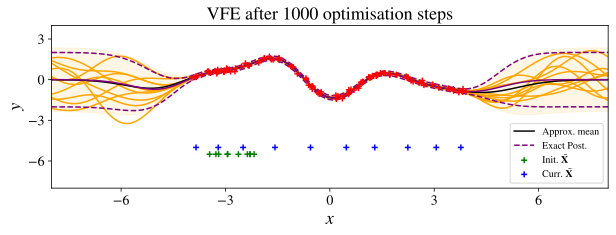

In [45]:
# Set random seed and tensor dtype
tf.random.set_seed(0)

# Number GP constants
M = 10
inducing_range = (-4., -2.)
log_noise = np.log(1e-1)
log_coeff = np.log(1e0)
log_scales = [np.log(1e0)]
trainable = True

# Define mean and covariance
mean = ConstantMean(dtype=dtype)

cov = EQcovariance(log_coeff=log_coeff,
                   log_scales=log_scales,
                   dim=1,
                   dtype=dtype,
                   trainable=trainable)

# Initial locations of inducing points
x_ind_dist = tfp.distributions.Uniform(*inducing_range)
x_ind_init = x_ind_dist.sample(sample_shape=(M, 1))
x_ind_init = tf.cast(x_ind_init, dtype=dtype)

# Re-define sparse VFEGP with trainable noise
vfe_gp = VFEGP(mean=mean,
               cov=cov,
               log_noise=log_noise,
               x_train=x_train,
               y_train=y_train,
               x_ind_init=x_ind_init,
               dtype=dtype,
               trainable_noise=trainable)

num_steps = 1000
optimizer = tf.keras.optimizers.Adam(1e-1)

x_pred = tf.linspace(-8., 8., 100)[:, None]
x_pred = tf.cast(x_pred, dtype=dtype)

for step in range(num_steps + 1):
    
    with tf.GradientTape() as tape:

        free_energy = vfe_gp.free_energy()
        loss = - free_energy

    gradients = tape.gradient(loss, vfe_gp.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vfe_gp.trainable_variables))
          
# Print optimisation information
print_info(vfe_gp, step)

# Plot posterior
plot(
    vfe_gp,
    ground_truth_cov,
    noise,
    x_pred,
    x_train,
    y_train,
    x_ind_init,
    step,
    plot_post_pred=True,
    num_samples=10
)

First, we obsereve that the VFE GP posterior (shaded yellow), closely matches the exact posterior (dashed purple). The samples drawn by path-wise conditioning (yellow lines) appear qualitatively good, matching the VFE posterior. Note that calling `vfe_gp.sample_posterior` returns a function which can be queried and differentiated at arbitrary input locations - at constant time once the sample has been drawn.

### Sinusoidal data

We can also train the model on a dataset similar to the one used in the [sinusoidal data used in the RFF example](../../misc/rff/rff), where we observed that an approximate sparse posterior based solely on RFFs gave a rather poor approximation (see second dataset in example). The poor performance of RFF is due to the fact that an RFF-only model is equivalent to a finite basis function model, whose weights are quickly pinned down once enough data have been observed, leading to overly narrow error bars, a behaviour which is referred to as variance starvation.

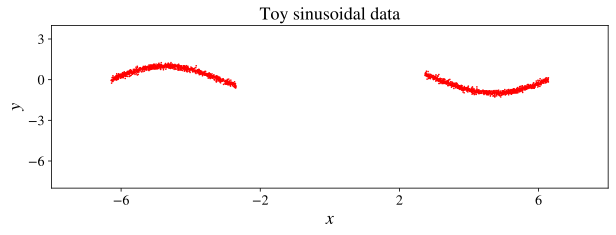

In [46]:
# Number of datapoints to generate
num_data = 3000

# Generate sinusoidal data with a gap in input space
x_train_sine = 4 * np.pi * (np.random.uniform(size=(5 * num_data // 4, 1)) - 0.5)
x_train_sine = np.sort(x_train_sine, axis=0)
x_train_sine = np.concatenate([x_train_sine[:(2*x_train_sine.shape[0]//7)],
                               x_train_sine[-(2*x_train_sine.shape[0]//7):]],
                              axis=0)
y_train_sine = np.sin(x_train_sine) + 1e-1 * np.random.normal(size=x_train_sine.shape)
        
# Plot data
plt.figure(figsize=(10, 3))
    
# Plot data points
plt.scatter(x_train_sine, y_train_sine, marker='+', color='red', s=1, alpha=1.0)

# Format plot
plt.title('Toy sinusoidal data', fontsize=18)

plt.xlabel('$x$', fontsize=18)
plt.ylabel('$y$', fontsize=18)

plt.xticks(np.arange(-10, 11, 4), fontsize=14)
plt.yticks(np.arange(-6, 7, 3), fontsize=14)

plt.xlim([-8., 8.])
plt.ylim([-8., 4.])

plt.show()

Step: 1000 Free energy:    0.739 Coeff:  0.76 Scales: [1.39] Noise:  0.07


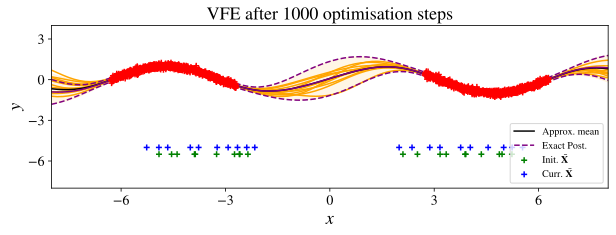

In [47]:
# Set random seed and tensor dtype
tf.random.set_seed(0)

# Number GP constants
M = 20
inducing_ranges = [(-6., -2.),
                   ( 2.,  6.)]
log_noise = np.log(1e-2)
log_coeff = np.log(1e0)
log_scales = [np.log(1e0)]
trainable = True

# Define mean and covariance
mean = ConstantMean(dtype=dtype)

cov = EQcovariance(log_coeff=log_coeff,
                   log_scales=log_scales,
                   dim=1,
                   dtype=dtype,
                   trainable=trainable)

# Initial locations of inducing points
x_ind_dist1 = tfp.distributions.Uniform(*inducing_ranges[0])
x_ind_dist2 = tfp.distributions.Uniform(*inducing_ranges[1])
x_ind_init = tf.concat(
    [x_ind_dist1.sample(sample_shape=(M//2, 1)),
     x_ind_dist2.sample(sample_shape=(M//2, 1))],
    axis=0
)
x_ind_init = tf.cast(x_ind_init, dtype=dtype)

# Re-define sparse VFEGP with trainable noise
vfe_gp = VFEGP(mean=mean,
               cov=cov,
               log_noise=log_noise,
               x_train=x_train_sine,
               y_train=y_train_sine,
               x_ind_init=x_ind_init,
               dtype=dtype,
               trainable_noise=trainable)

num_steps = 1000
optimizer = tf.keras.optimizers.Adam(1e-2)

x_pred = tf.linspace(-8., 8., 100)[:, None]
x_pred = tf.cast(x_pred, dtype=dtype)

for step in range(num_steps + 1):
    
    with tf.GradientTape() as tape:

        free_energy = vfe_gp.free_energy()
        loss = - free_energy

    gradients = tape.gradient(loss, vfe_gp.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vfe_gp.trainable_variables))
          
# Print optimisation information
print_info(vfe_gp, step)

# EQ covariance hyperparameters
log_coeff = vfe_gp.cov.log_coeff
log_scale = vfe_gp.cov.log_scales[0]
noise = vfe_gp.noise
dim = 1

# Initialise covariance
exact_cov = EQcovariance(log_coeff=log_coeff,
                         log_scales=log_scale,
                         dim=dim,
                         dtype=dtype)

# Plot posterior
plot(
    vfe_gp,
    exact_cov,
    noise,
    x_pred,
    x_train_sine,
    y_train_sine,
    x_ind_init,
    step,
    plot_post_pred=True,
    num_samples=10
)

We observe that the VFE GP has produced a sensible posterior. The VFE posterior matches the exact posterior quite closely indicating that the inducing points summarise the exact posterior accurately. In addition, we observe that pathwise conditioning has produced sensible samples, which do not suffer from variance starvation. In an RFF-based approximate model, the weights of the basis functions are constrained such that the weighted sum of the features passees close to the datapoints, thus constraining the model severely across all inputs. In the pathwise conditioning approximation, this issue is no longer present because the uncertainty in the inducing point outputs helps maintain the uncertainty in the samples, outside the range of the data.

## Conclusion

We have seen how RFFs can be used in conjuction with the VFE approximation to efficiently draw samples from approximate GP posteriors. Matheron's rule allows us to condition RFF samples to particular values of the pseudopoints. This  procedure yields high quality samples which can be queried and differentiated at arbitrary input locations. There is a host of useful applications that these samples can be used for, ranging from Thompson-sampling Bayesian Optimisation, posterior sampling for simulating dynamical systems whose dynamics are governed by GPs and many other interesting problems. The original paper Wilson et al. {cite}`wilson2020efficiently` as well as the extended journal paper by the same authors {cite}`wislon2021pathwise` give a great deal of experimental results and theoretical analysis for this method.

## References

```{bibliography} ./gp-sampling.bib
```